In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Paths
train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'


In [ ]:
#Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
#Load Datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
#Model Setup (VGG16)
model = vgg16(pretrained=True)

#Unfreeze last two convolutional blocks
for name, param in model.features.named_parameters():
    if '28' in name or '27' in name or '26' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

#Modify classifier with dropout
model.classifier[6] = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(4096, 4)
)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
#Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#Training Function
def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        acc = 100 * correct / total
        train_losses.append(total_loss)
        train_accuracies.append(acc)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {acc:.2f}%")

Epoch 1/5, Loss: 93.9707, Accuracy: 80.93%
Epoch 2/5, Loss: 58.0491, Accuracy: 89.76%
Epoch 3/5, Loss: 44.1844, Accuracy: 91.87%
Epoch 4/5, Loss: 24.3280, Accuracy: 95.26%
Epoch 5/5, Loss: 18.8119, Accuracy: 96.50%


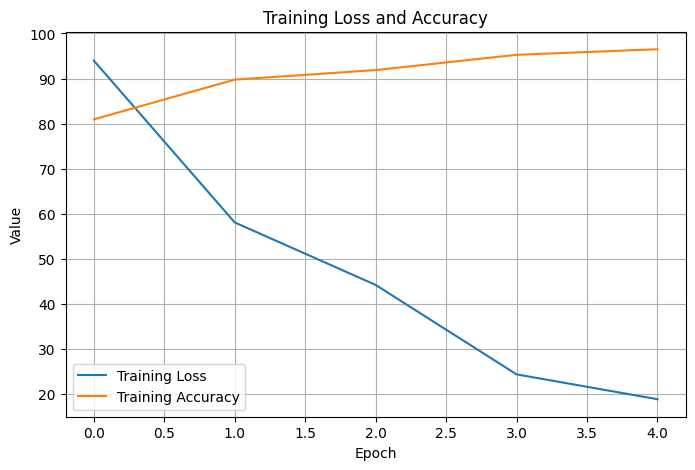

In [ ]:
#Training
train_losses = []
train_accuracies = []
train_model(model, train_loader, epochs=5)

#Training Plot
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Model Evaluation
model.eval()
y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())
        y_prob.extend(probs.cpu().numpy())


In [ ]:
#Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.82      0.88       300
  meningioma       0.83      0.89      0.85       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.95      0.98      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



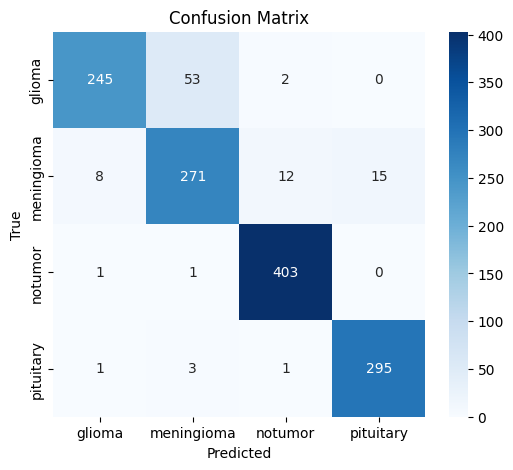

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

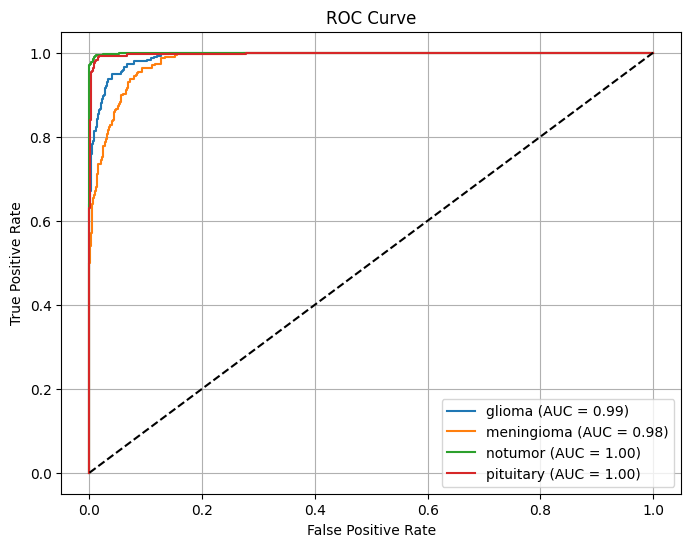

In [ ]:
#ROC Curve
y_true_bin = np.eye(4)[y_true]
y_prob = np.array(y_prob)

plt.figure(figsize=(8,6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{train_dataset.classes[i]} (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Save Model
model_path = "/content/mri_tumor_vgg16_finetuned.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/mri_tumor_vgg16_finetuned.pth


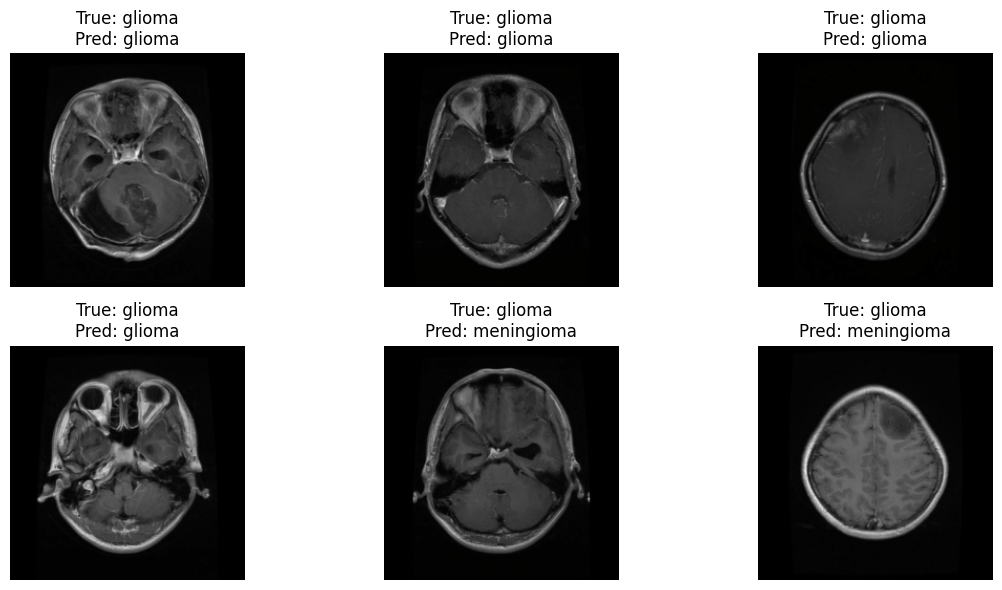

In [ ]:
#Visualize Predictions
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 6))
for idx in range(6):
    ax = fig.add_subplot(2, 3, idx + 1)
    imshow(images[idx])
    ax.set_title(f"True: {train_dataset.classes[labels[idx]]}\nPred: {train_dataset.classes[preds[idx]]}")
plt.tight_layout()
plt.show()

In [ ]:
#Prediction Visualization
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')



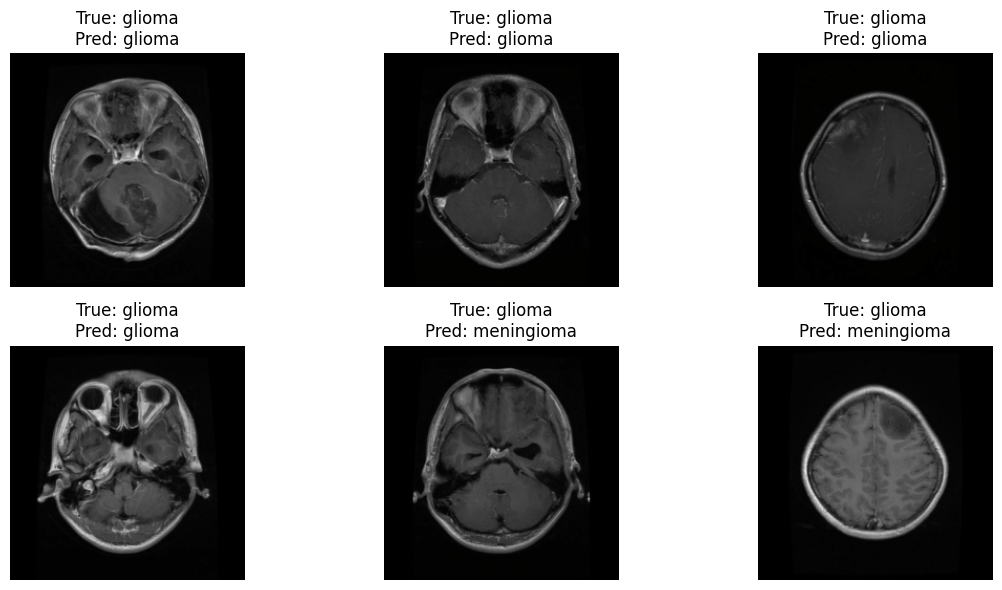

In [ ]:
#Visualize few predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 6))
for idx in range(6):
    ax = fig.add_subplot(2, 3, idx + 1)
    imshow(images[idx])
    ax.set_title(f"True: {train_dataset.classes[labels[idx]]}\nPred: {train_dataset.classes[preds[idx]]}")
plt.tight_layout()
plt.show()